In [ ]:
!pip install mne
!pip install pyedflib
!pip install PyWavelets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 67.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 76.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/commands/install.py", line 423, in run
    _, build_failures = build(
                        ^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/wheel_builder.py", line 319, in build
    wheel_file = _build_

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import mne
import pywt
import imageio
import os
from PIL import Image
import cv2
import pandas as pd


In [ ]:
!unzip /content/drive/MyDrive/eeg/EEG_1.zip -d /content/data1
!unzip /content/drive/MyDrive/eeg/EEG_2.zip -d /content/data2

Archive:  /content/drive/MyDrive/eeg/EEG_1.zip
  inflating: /content/data1/15.edf   
  inflating: /content/data1/16.edf   
  inflating: /content/data1/17.edf   
  inflating: /content/data1/18.edf   
  inflating: /content/data1/19.edf   
  inflating: /content/data1/20.edf   
  inflating: /content/data1/21.edf   
  inflating: /content/data1/22.edf   
  inflating: /content/data1/23.edf   
  inflating: /content/data1/24.edf   
  inflating: /content/data1/25.edf   
  inflating: /content/data1/26.edf   
  inflating: /content/data1/27.edf   
  inflating: /content/data1/1.edf    
  inflating: /content/data1/2.edf    
  inflating: /content/data1/3.edf    
  inflating: /content/data1/4.edf    
  inflating: /content/data1/5.edf    
  inflating: /content/data1/6.edf    
  inflating: /content/data1/7.edf    
  inflating: /content/data1/8.edf    
  inflating: /content/data1/9.edf    
  inflating: /content/data1/10.edf   
  inflating: /content/data1/11.edf   
  inflating: /content/data1/12.edf   
  i

## 1. Đọc dữ liệu và label

In [ ]:
data_dir_1  = "/content/data1"
data_dir_2  = "/content/data2"
raw_data = []
lables = []
for filename in os.listdir(data_dir_1):
    if filename.endswith(".edf"):
        file_path = os.path.join(data_dir_1, filename)
        raw = mne.io.read_raw_edf(file_path,preload=True)
        raw_data.append(raw)
        # Kiểm tra thông tin
        print(f'Tên tệp: {filename}')
        print(f'Số kênh: {len(raw.ch_names)}')
        print(f'Tần số lấy mẫu: {raw.info["sfreq"]} Hz')
        print(f'Thời gian ghi: {raw.times[-1]} giây')
for filename in os.listdir(data_dir_2):
    if filename.endswith(".edf"):
        file_path = os.path.join(data_dir_2, filename)
        raw = mne.io.read_raw_edf(file_path,preload=True)
        raw_data.append(raw)

Extracting EDF parameters from /content/data1/7.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 476671  =      0.000 ...  1861.996 secs...
Tên tệp: 7.edf
Số kênh: 19
Tần số lấy mẫu: 256.0 Hz
Thời gian ghi: 1861.99609375 giây
Extracting EDF parameters from /content/data1/17.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 492287  =      0.000 ...  1922.996 secs...
Tên tệp: 17.edf
Số kênh: 19
Tần số lấy mẫu: 256.0 Hz
Thời gian ghi: 1922.99609375 giây
Extracting EDF parameters from /content/data1/27.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 491775  =      0.000 ...  1920.996 secs...
Tên tệp: 27.edf
Số kênh: 19
Tần số lấy mẫu: 256.0 Hz
Thời gian ghi: 1920.99609375 giây
Extracting EDF parameters from /content/data1/3.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4

In [ ]:
file_path = '/content/data1/states.xlsx'
df_labels = pd.read_excel(file_path)

labels1 = df_labels['status']
labels1 = labels1.tolist()
file_path2 = '/content/data2/States.xlsx'
df_labels2 = pd.read_excel(file_path2)

labels2 = df_labels2['status'].tolist()

labels = labels1 + labels2
for i in range(len(labels)):
    if labels[i] == 'NORMAL':
        labels[i] = 0
    elif labels[i] == 'MCI':
        labels[i] = 1

## 2. Lọc nhiễu và lọc tần số

In [ ]:
from mne.preprocessing import ICA
for raw in raw_data:
    raw.filter(l_freq=0.5, h_freq=40, fir_design='firwin', verbose=False)

for raw in raw_data:
    # Chuẩn hóa dữ liệu
    data = raw.get_data()
    data = (data - data.mean(axis=1, keepdims=True)) / data.std(axis=1, keepdims=True)
    raw._data = data

    # Fit ICA
    ica = ICA(n_components=15, random_state=42, max_iter=800)
    ica.fit(raw)

    # Kiểm tra và đặt kênh EOG
    eog_channels = [ch for ch in raw.ch_names if 'EOG' in ch.upper()]
    if not eog_channels:
        print("Không tìm thấy kênh EOG, dùng Fp1 và Fp2 làm kênh EOG thay thế...")
        raw.set_channel_types({'Fp1': 'eog', 'Fp2': 'eog'})
        eog_indices, eog_scores = ica.find_bads_eog(raw, ch_name=['Fp1', 'Fp2'])
        raw.set_channel_types({'Fp1': 'eeg', 'Fp2': 'eeg'})  # Đặt lại
    else:
        eog_indices, eog_scores = ica.find_bads_eog(raw)

    # Gán thành phần nhiễu
    ica.exclude = eog_indices
    print(f'Thành phần nháy mắt: {eog_indices}')

    # Áp dụng ICA
    raw_clean = ica.apply(raw.copy())
    raw._data = raw_clean.get_data()

Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 10.3s.
Không tìm thấy kênh EOG, dùng Fp1 và Fp2 làm kênh EOG thay thế...
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann wind

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 sam

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


    Transforming to ICA space (15 components)
    Zeroing out 2 ICA components
    Projecting back using 19 PCA components
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 9.2s.
Không tìm thấy kênh EOG, dùng Fp1 và Fp2 làm kênh EOG thay thế...
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass fo

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 sam

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Thành phần nháy mắt: [np.int64(2), np.int64(3)]
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 2 ICA components
    Projecting back using 19 PCA components
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 5.0s.
Không tìm thấy kênh EOG, dùng Fp1 và Fp2 làm kênh EOG thay thế...
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 sam

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Thành phần nháy mắt: [np.int64(3), np.int64(1)]
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 2 ICA components
    Projecting back using 19 PCA components
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 7.8s.
Không tìm thấy kênh EOG, dùng Fp1 và Fp2 làm kênh EOG thay thế...
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 sam

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Thành phần nháy mắt: [np.int64(2)]
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 19 PCA components
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 11.1s.
Không tìm thấy kênh EOG, dùng Fp1 và Fp2 làm kênh EOG thay thế...
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 sam

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 2.4s.
Không tìm thấy kênh EOG, dùng Fp1 và Fp2 làm kênh EOG thay thế...
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass fo

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 sam

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


    Transforming to ICA space (15 components)
    Zeroing out 2 ICA components
    Projecting back using 19 PCA components
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 5.5s.
Không tìm thấy kênh EOG, dùng Fp1 và Fp2 làm kênh EOG thay thế...
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass fo

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 sam

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Thành phần nháy mắt: [np.int64(3)]
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 19 PCA components
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 5.0s.
Không tìm thấy kênh EOG, dùng Fp1 và Fp2 làm kênh EOG thay thế...
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR 

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 sam

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 19 PCA components
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 7.7s.
Không tìm thấy kênh EOG, dùng Fp1 và Fp2 làm kênh EOG thay thế...
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass for

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 sam

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Thành phần nháy mắt: [np.int64(1)]
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 19 PCA components
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 4.4s.
Không tìm thấy kênh EOG, dùng Fp1 và Fp2 làm kênh EOG thay thế...
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR 

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 sam

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


    Transforming to ICA space (15 components)
    Zeroing out 2 ICA components
    Projecting back using 19 PCA components
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 9.4s.
Không tìm thấy kênh EOG, dùng Fp1 và Fp2 làm kênh EOG thay thế...
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass fo

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 sam

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 19 PCA components
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 3.8s.
Không tìm thấy kênh EOG, dùng Fp1 và Fp2 làm kênh EOG thay thế...
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass for

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 sam

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Thành phần nháy mắt: []
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 7.3s.
Không tìm thấy kênh EOG, dùng Fp1 và Fp2 làm kênh EOG thay thế...
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter par

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 sam

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


    Transforming to ICA space (15 components)
    Zeroing out 2 ICA components
    Projecting back using 19 PCA components
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 8.0s.
Không tìm thấy kênh EOG, dùng Fp1 và Fp2 làm kênh EOG thay thế...
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass fo

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 sam

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Thành phần nháy mắt: [np.int64(4)]
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 19 PCA components
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 5.6s.
Không tìm thấy kênh EOG, dùng Fp1 và Fp2 làm kênh EOG thay thế...
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR 

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 sam

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Thành phần nháy mắt: [np.int64(4)]
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 19 PCA components
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 7.0s.
Không tìm thấy kênh EOG, dùng Fp1 và Fp2 làm kênh EOG thay thế...
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR 

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 sam

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Thành phần nháy mắt: [np.int64(2), np.int64(1)]
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 2 ICA components
    Projecting back using 19 PCA components
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 2.7s.
Không tìm thấy kênh EOG, dùng Fp1 và Fp2 làm kênh EOG thay thế...
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 sam

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 3.4s.
Không tìm thấy kênh EOG, dùng Fp1 và Fp2 làm kênh EOG thay thế...
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass fo

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 sam

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Thành phần nháy mắt: []
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 3.2s.
Không tìm thấy kênh EOG, dùng Fp1 và Fp2 làm kênh EOG thay thế...
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter par

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 sam

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Thành phần nháy mắt: []
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 4.9s.
Không tìm thấy kênh EOG, dùng Fp1 và Fp2 làm kênh EOG thay thế...
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter par

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 sam

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Thành phần nháy mắt: []
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 6.6s.
Không tìm thấy kênh EOG, dùng Fp1 và Fp2 làm kênh EOG thay thế...
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter par

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 sam

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Thành phần nháy mắt: [np.int64(3), np.int64(4)]
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 2 ICA components
    Projecting back using 19 PCA components
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 5.1s.
Không tìm thấy kênh EOG, dùng Fp1 và Fp2 làm kênh EOG thay thế...
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 sam

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Thành phần nháy mắt: [np.int64(3), np.int64(1)]
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 2 ICA components
    Projecting back using 19 PCA components
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 3.4s.
Không tìm thấy kênh EOG, dùng Fp1 và Fp2 làm kênh EOG thay thế...
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 sam

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 19 PCA components
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 6.4s.
Không tìm thấy kênh EOG, dùng Fp1 và Fp2 làm kênh EOG thay thế...
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass for

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 sam

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Thành phần nháy mắt: [np.int64(3)]
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 19 PCA components
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 5.8s.
Không tìm thấy kênh EOG, dùng Fp1 và Fp2 làm kênh EOG thay thế...
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR 

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 sam

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Thành phần nháy mắt: [np.int64(0)]
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 19 PCA components
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 6.4s.
Không tìm thấy kênh EOG, dùng Fp1 và Fp2 làm kênh EOG thay thế...
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR 

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 sam

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Thành phần nháy mắt: [np.int64(3), np.int64(2)]
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 2 ICA components
    Projecting back using 19 PCA components
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 8.6s.
Không tìm thấy kênh EOG, dùng Fp1 và Fp2 làm kênh EOG thay thế...
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 sam

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Thành phần nháy mắt: [np.int64(1), np.int64(2)]
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 2 ICA components
    Projecting back using 19 PCA components
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 10.2s.
Không tìm thấy kênh EOG, dùng Fp1 và Fp2 làm kênh EOG thay thế...
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 sam

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Thành phần nháy mắt: []
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 10.4s.
Không tìm thấy kênh EOG, dùng Fp1 và Fp2 làm kênh EOG thay thế...
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter pa

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 sam

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Thành phần nháy mắt: [np.int64(4), np.int64(1)]
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 2 ICA components
    Projecting back using 19 PCA components
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 8.2s.
Không tìm thấy kênh EOG, dùng Fp1 và Fp2 làm kênh EOG thay thế...
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 sam

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Thành phần nháy mắt: [np.int64(5)]
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 19 PCA components
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 5.2s.
Không tìm thấy kênh EOG, dùng Fp1 và Fp2 làm kênh EOG thay thế...
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR 

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 sam

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 10.1s.
Không tìm thấy kênh EOG, dùng Fp1 và Fp2 làm kênh EOG thay thế...
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass f

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 sam

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Thành phần nháy mắt: [np.int64(7)]
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 19 PCA components
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 8.4s.
Không tìm thấy kênh EOG, dùng Fp1 và Fp2 làm kênh EOG thay thế...
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR 

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 sam

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Thành phần nháy mắt: []
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 4.3s.
Không tìm thấy kênh EOG, dùng Fp1 và Fp2 làm kênh EOG thay thế...
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter par

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 sam

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


    Transforming to ICA space (15 components)
    Zeroing out 2 ICA components
    Projecting back using 19 PCA components
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 5.5s.
Không tìm thấy kênh EOG, dùng Fp1 và Fp2 làm kênh EOG thay thế...
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass fo

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 sam

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Thành phần nháy mắt: [np.int64(4)]
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 19 PCA components
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 6.3s.
Không tìm thấy kênh EOG, dùng Fp1 và Fp2 làm kênh EOG thay thế...
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR 

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 sam

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Thành phần nháy mắt: [np.int64(3), np.int64(4)]
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 2 ICA components
    Projecting back using 19 PCA components
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 5.8s.
Không tìm thấy kênh EOG, dùng Fp1 và Fp2 làm kênh EOG thay thế...
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 sam

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Thành phần nháy mắt: [np.int64(3)]
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 19 PCA components
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 6.2s.
Không tìm thấy kênh EOG, dùng Fp1 và Fp2 làm kênh EOG thay thế...
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR 

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 sam

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Thành phần nháy mắt: []
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 5.2s.
Không tìm thấy kênh EOG, dùng Fp1 và Fp2 làm kênh EOG thay thế...
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter par

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 sam

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Thành phần nháy mắt: [np.int64(3), np.int64(5)]
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 2 ICA components
    Projecting back using 19 PCA components
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 3.9s.
Không tìm thấy kênh EOG, dùng Fp1 và Fp2 làm kênh EOG thay thế...
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 sam

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Thành phần nháy mắt: []
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 10.3s.
Không tìm thấy kênh EOG, dùng Fp1 và Fp2 làm kênh EOG thay thế...
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter pa

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 sam

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Thành phần nháy mắt: []
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 13.0s.
Không tìm thấy kênh EOG, dùng Fp1 và Fp2 làm kênh EOG thay thế...
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter pa

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 sam

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Thành phần nháy mắt: [np.int64(1)]
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 19 PCA components
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 10.0s.
Không tìm thấy kênh EOG, dùng Fp1 và Fp2 làm kênh EOG thay thế...
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 sam

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Thành phần nháy mắt: [np.int64(3), np.int64(5)]
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 2 ICA components
    Projecting back using 19 PCA components
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 6.0s.
Không tìm thấy kênh EOG, dùng Fp1 và Fp2 làm kênh EOG thay thế...
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 sam

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Thành phần nháy mắt: []
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 5.9s.
Không tìm thấy kênh EOG, dùng Fp1 và Fp2 làm kênh EOG thay thế...
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter par

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 sam

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Thành phần nháy mắt: []
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 10.4s.
Không tìm thấy kênh EOG, dùng Fp1 và Fp2 làm kênh EOG thay thế...
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter pa

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 sam

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Thành phần nháy mắt: []
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 7.5s.
Không tìm thấy kênh EOG, dùng Fp1 và Fp2 làm kênh EOG thay thế...
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter par

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 sam

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Thành phần nháy mắt: [np.int64(2), np.int64(4)]
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 2 ICA components
    Projecting back using 19 PCA components
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 5.1s.
Không tìm thấy kênh EOG, dùng Fp1 và Fp2 làm kênh EOG thay thế...
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 sam

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


    Transforming to ICA space (15 components)
    Zeroing out 2 ICA components
    Projecting back using 19 PCA components
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 8.2s.
Không tìm thấy kênh EOG, dùng Fp1 và Fp2 làm kênh EOG thay thế...
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass fo

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 sam

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Thành phần nháy mắt: []
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 4.4s.
Không tìm thấy kênh EOG, dùng Fp1 và Fp2 làm kênh EOG thay thế...
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter par

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 sam

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Thành phần nháy mắt: []
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 5.5s.
Không tìm thấy kênh EOG, dùng Fp1 và Fp2 làm kênh EOG thay thế...
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter par

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 sam

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Thành phần nháy mắt: [np.int64(4)]
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 19 PCA components
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 6.3s.
Không tìm thấy kênh EOG, dùng Fp1 và Fp2 làm kênh EOG thay thế...
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR 

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 sam

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Thành phần nháy mắt: [np.int64(4), np.int64(6)]
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 2 ICA components
    Projecting back using 19 PCA components
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 6.8s.
Không tìm thấy kênh EOG, dùng Fp1 và Fp2 làm kênh EOG thay thế...
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 sam

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Thành phần nháy mắt: [np.int64(5), np.int64(3)]
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 2 ICA components
    Projecting back using 19 PCA components
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 6.8s.
Không tìm thấy kênh EOG, dùng Fp1 và Fp2 làm kênh EOG thay thế...
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 sam

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 19 PCA components
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 3.0s.
Không tìm thấy kênh EOG, dùng Fp1 và Fp2 làm kênh EOG thay thế...
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass for

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 sam

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Thành phần nháy mắt: [np.int64(6), np.int64(4)]
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 2 ICA components
    Projecting back using 19 PCA components
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 7.6s.
Không tìm thấy kênh EOG, dùng Fp1 và Fp2 làm kênh EOG thay thế...
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 sam

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Thành phần nháy mắt: []
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 7.0s.
Không tìm thấy kênh EOG, dùng Fp1 và Fp2 làm kênh EOG thay thế...
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter par

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 sam

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Thành phần nháy mắt: [np.int64(6)]
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 19 PCA components
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 5.1s.
Không tìm thấy kênh EOG, dùng Fp1 và Fp2 làm kênh EOG thay thế...
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR 

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 sam

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Thành phần nháy mắt: [np.int64(3)]
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 19 PCA components
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 6.1s.
Không tìm thấy kênh EOG, dùng Fp1 và Fp2 làm kênh EOG thay thế...
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR 

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 sam

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Thành phần nháy mắt: [np.int64(2)]
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 19 PCA components
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 10.2s.
Không tìm thấy kênh EOG, dùng Fp1 và Fp2 làm kênh EOG thay thế...
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 sam

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Thành phần nháy mắt: []
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 7.8s.
Không tìm thấy kênh EOG, dùng Fp1 và Fp2 làm kênh EOG thay thế...
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter par

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 sam

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Thành phần nháy mắt: []
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components


## 3. Trích xuất stack spectrogram

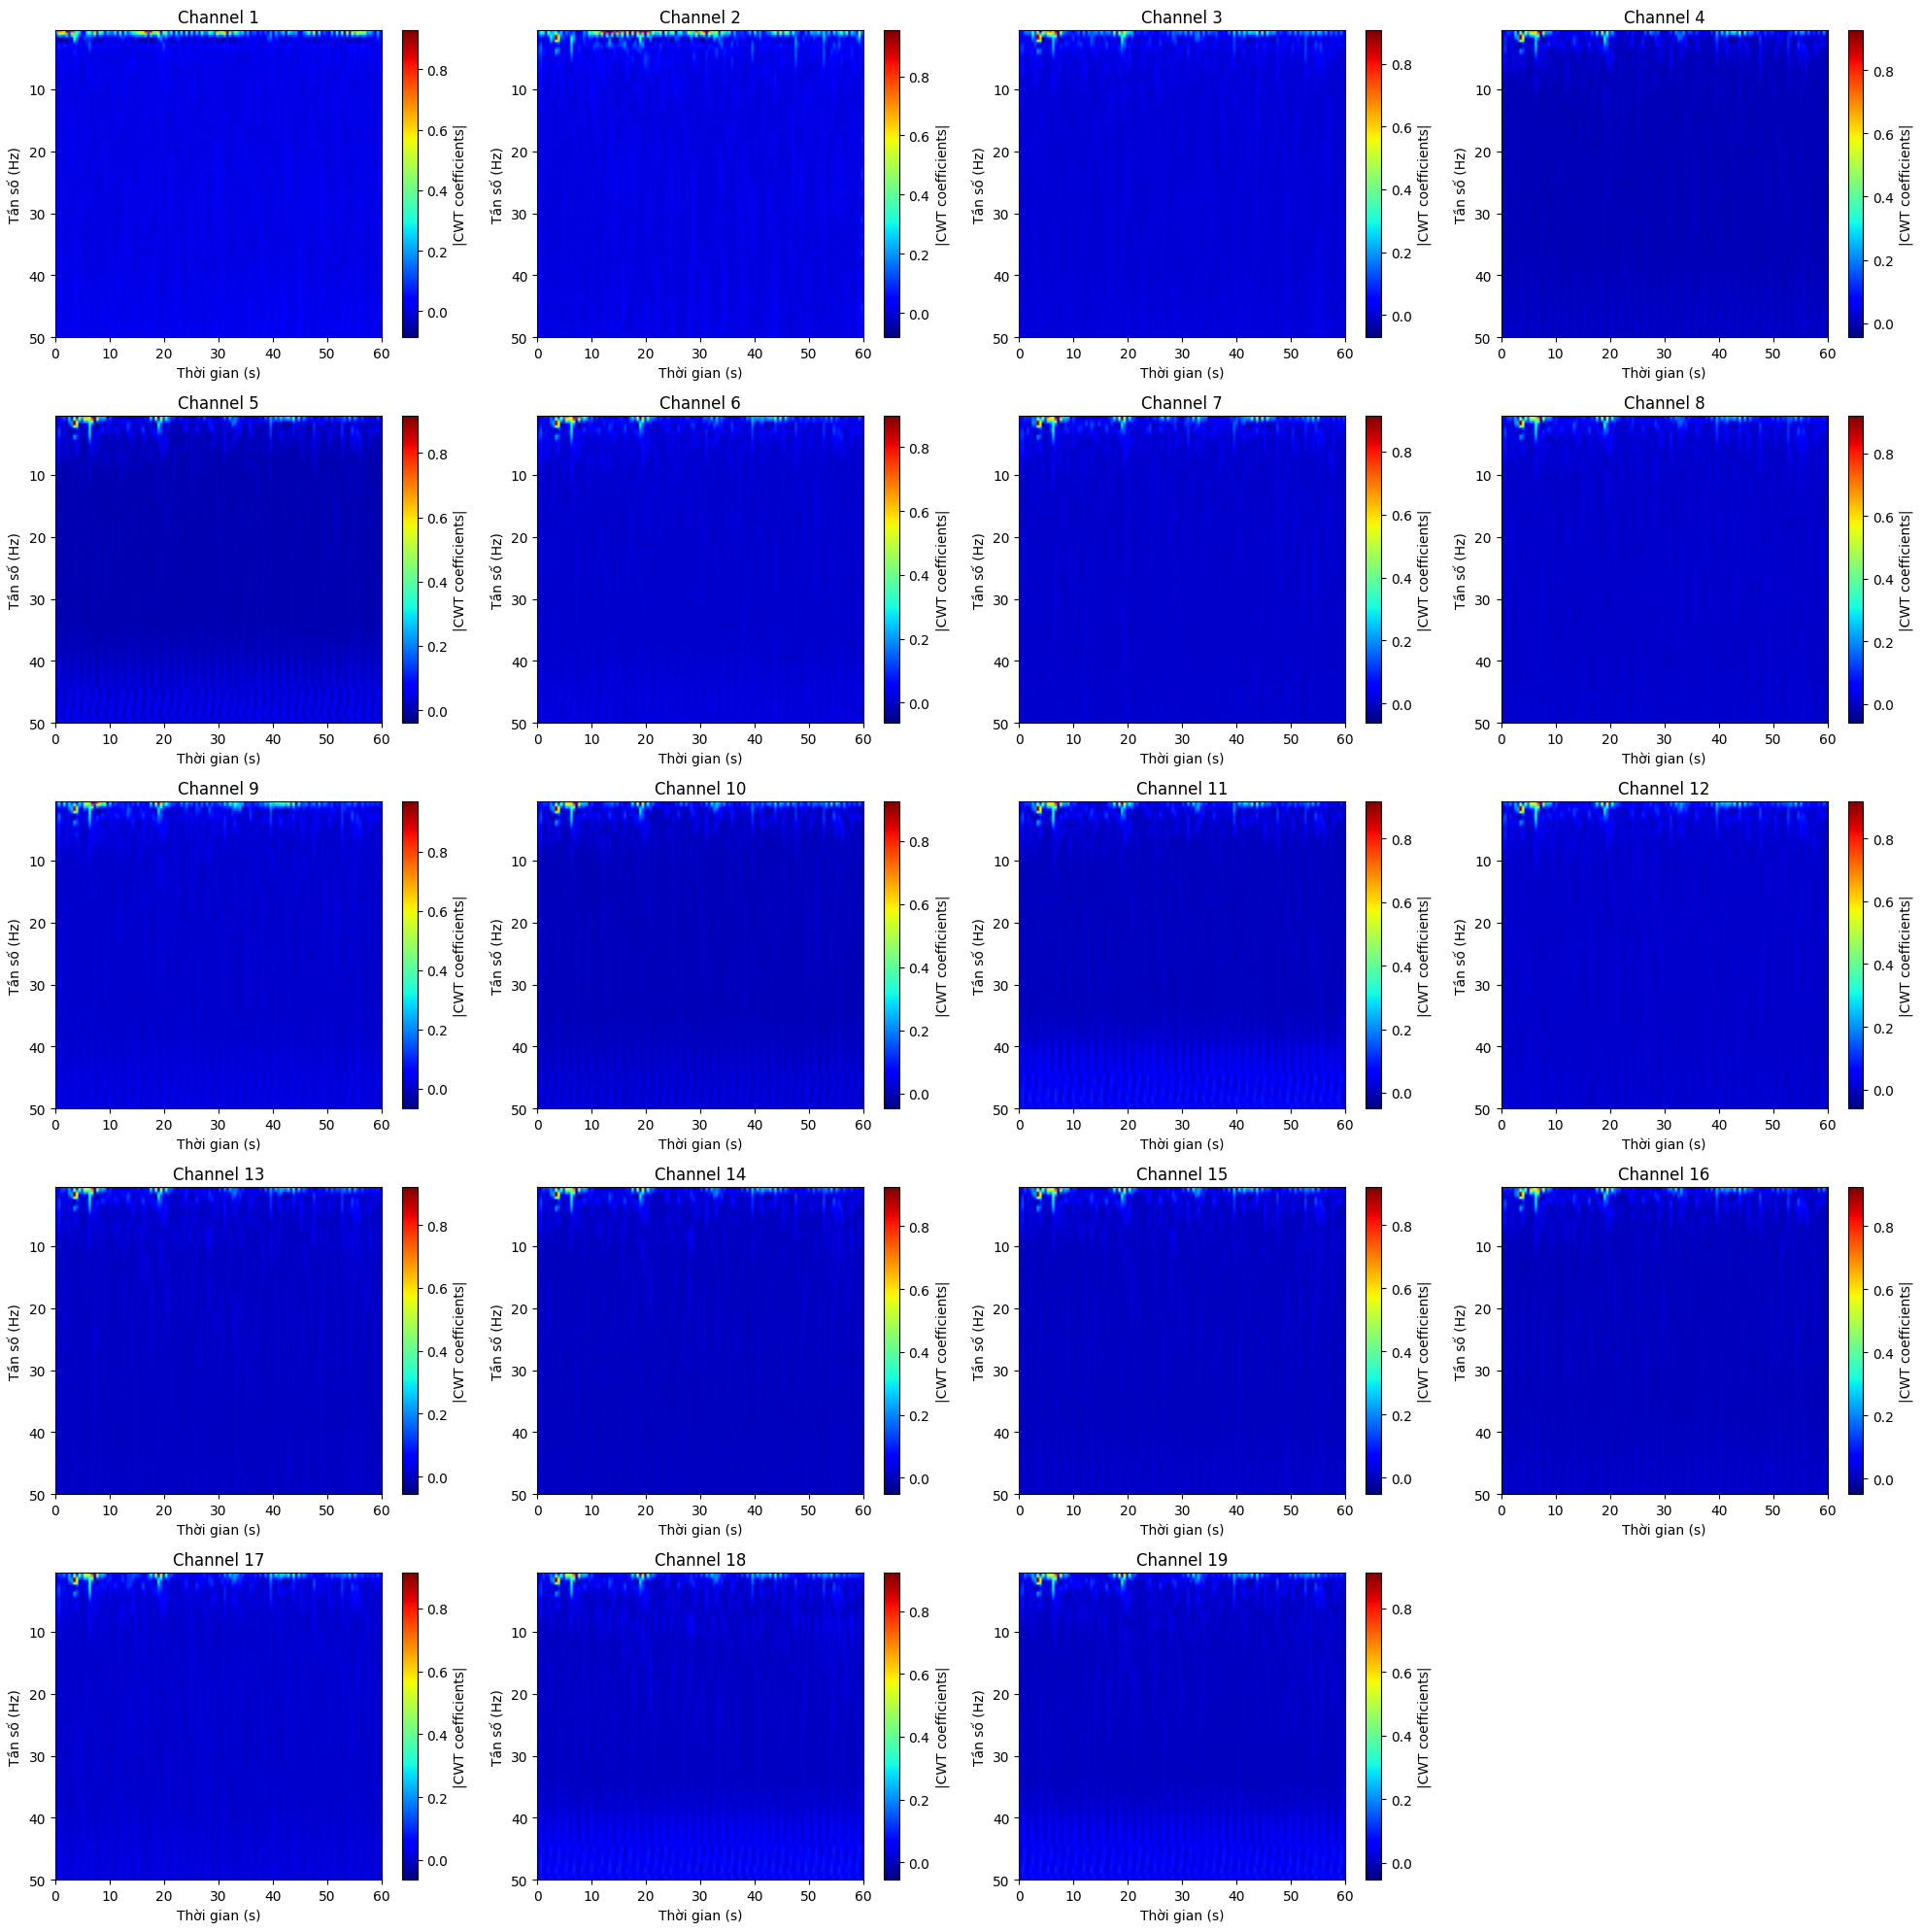

In [ ]:
import mne
import numpy as np
import matplotlib.pyplot as plt
import pywt
from scipy.ndimage import zoom

raw = mne.io.read_raw_edf("/content/data1/1.edf", preload=True, verbose=False)
signals, times = raw.get_data(return_times=True)  # Shape: (19, n_samples)

sfreq = raw.info['sfreq']  # Tần số lấy mẫu thực tế
duration_sec = 60
n_samples = int(sfreq * duration_sec)
segment = signals[:, 0:0 + n_samples]
wavelet = 'morl'  # Morlet wavelet
freqs_range = np.linspace(0.5, 50, 50)  # Tập trung vào 0.5–50 Hz
central_freq = pywt.central_frequency(wavelet)
scales = central_freq / (freqs_range * (1/sfreq))  # Tính scales dựa trên tần số

# Khởi tạo tensor 3D
tensor_3d = np.zeros((19, 128, 128))  # Shape: (19 channels, 128 freq, 128 time)

for ch in range(19):
    coefficients, freqs = pywt.cwt(segment[ch], scales, wavelet, sampling_period=1/sfreq)
    spectrogram = np.abs(coefficients)
    # Chuẩn hóa spectrogram về [0, 1]
    spectrogram = (spectrogram - spectrogram.min()) / (spectrogram.max() - spectrogram.min())
    # Resize spectrogram về 128x128
    spectrogram = zoom(spectrogram, (128/spectrogram.shape[0], 128/spectrogram.shape[1]))
    tensor_3d[ch, :, :] = spectrogram

# Bước 4: Trực quan hóa 19 ảnh spectrogram
plt.figure(figsize=(20, 20))
for ch in range(19):
    plt.subplot(5, 4, ch + 1)  # Sắp xếp thành lưới 5x4 (19 ảnh + 1 ô trống)
    plt.imshow(tensor_3d[ch], extent=[0, duration_sec, freqs[-1], freqs[0]],
               cmap='jet', aspect='auto')
    plt.title(f'Channel {ch + 1}')
    plt.xlabel("Thời gian (s)")
    plt.ylabel("Tần số (Hz)")
    plt.colorbar(label='|CWT coefficients|')
plt.tight_layout()
plt.show()

Extracting EDF parameters from /content/data1/1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 465663  =      0.000 ...  1818.996 secs...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


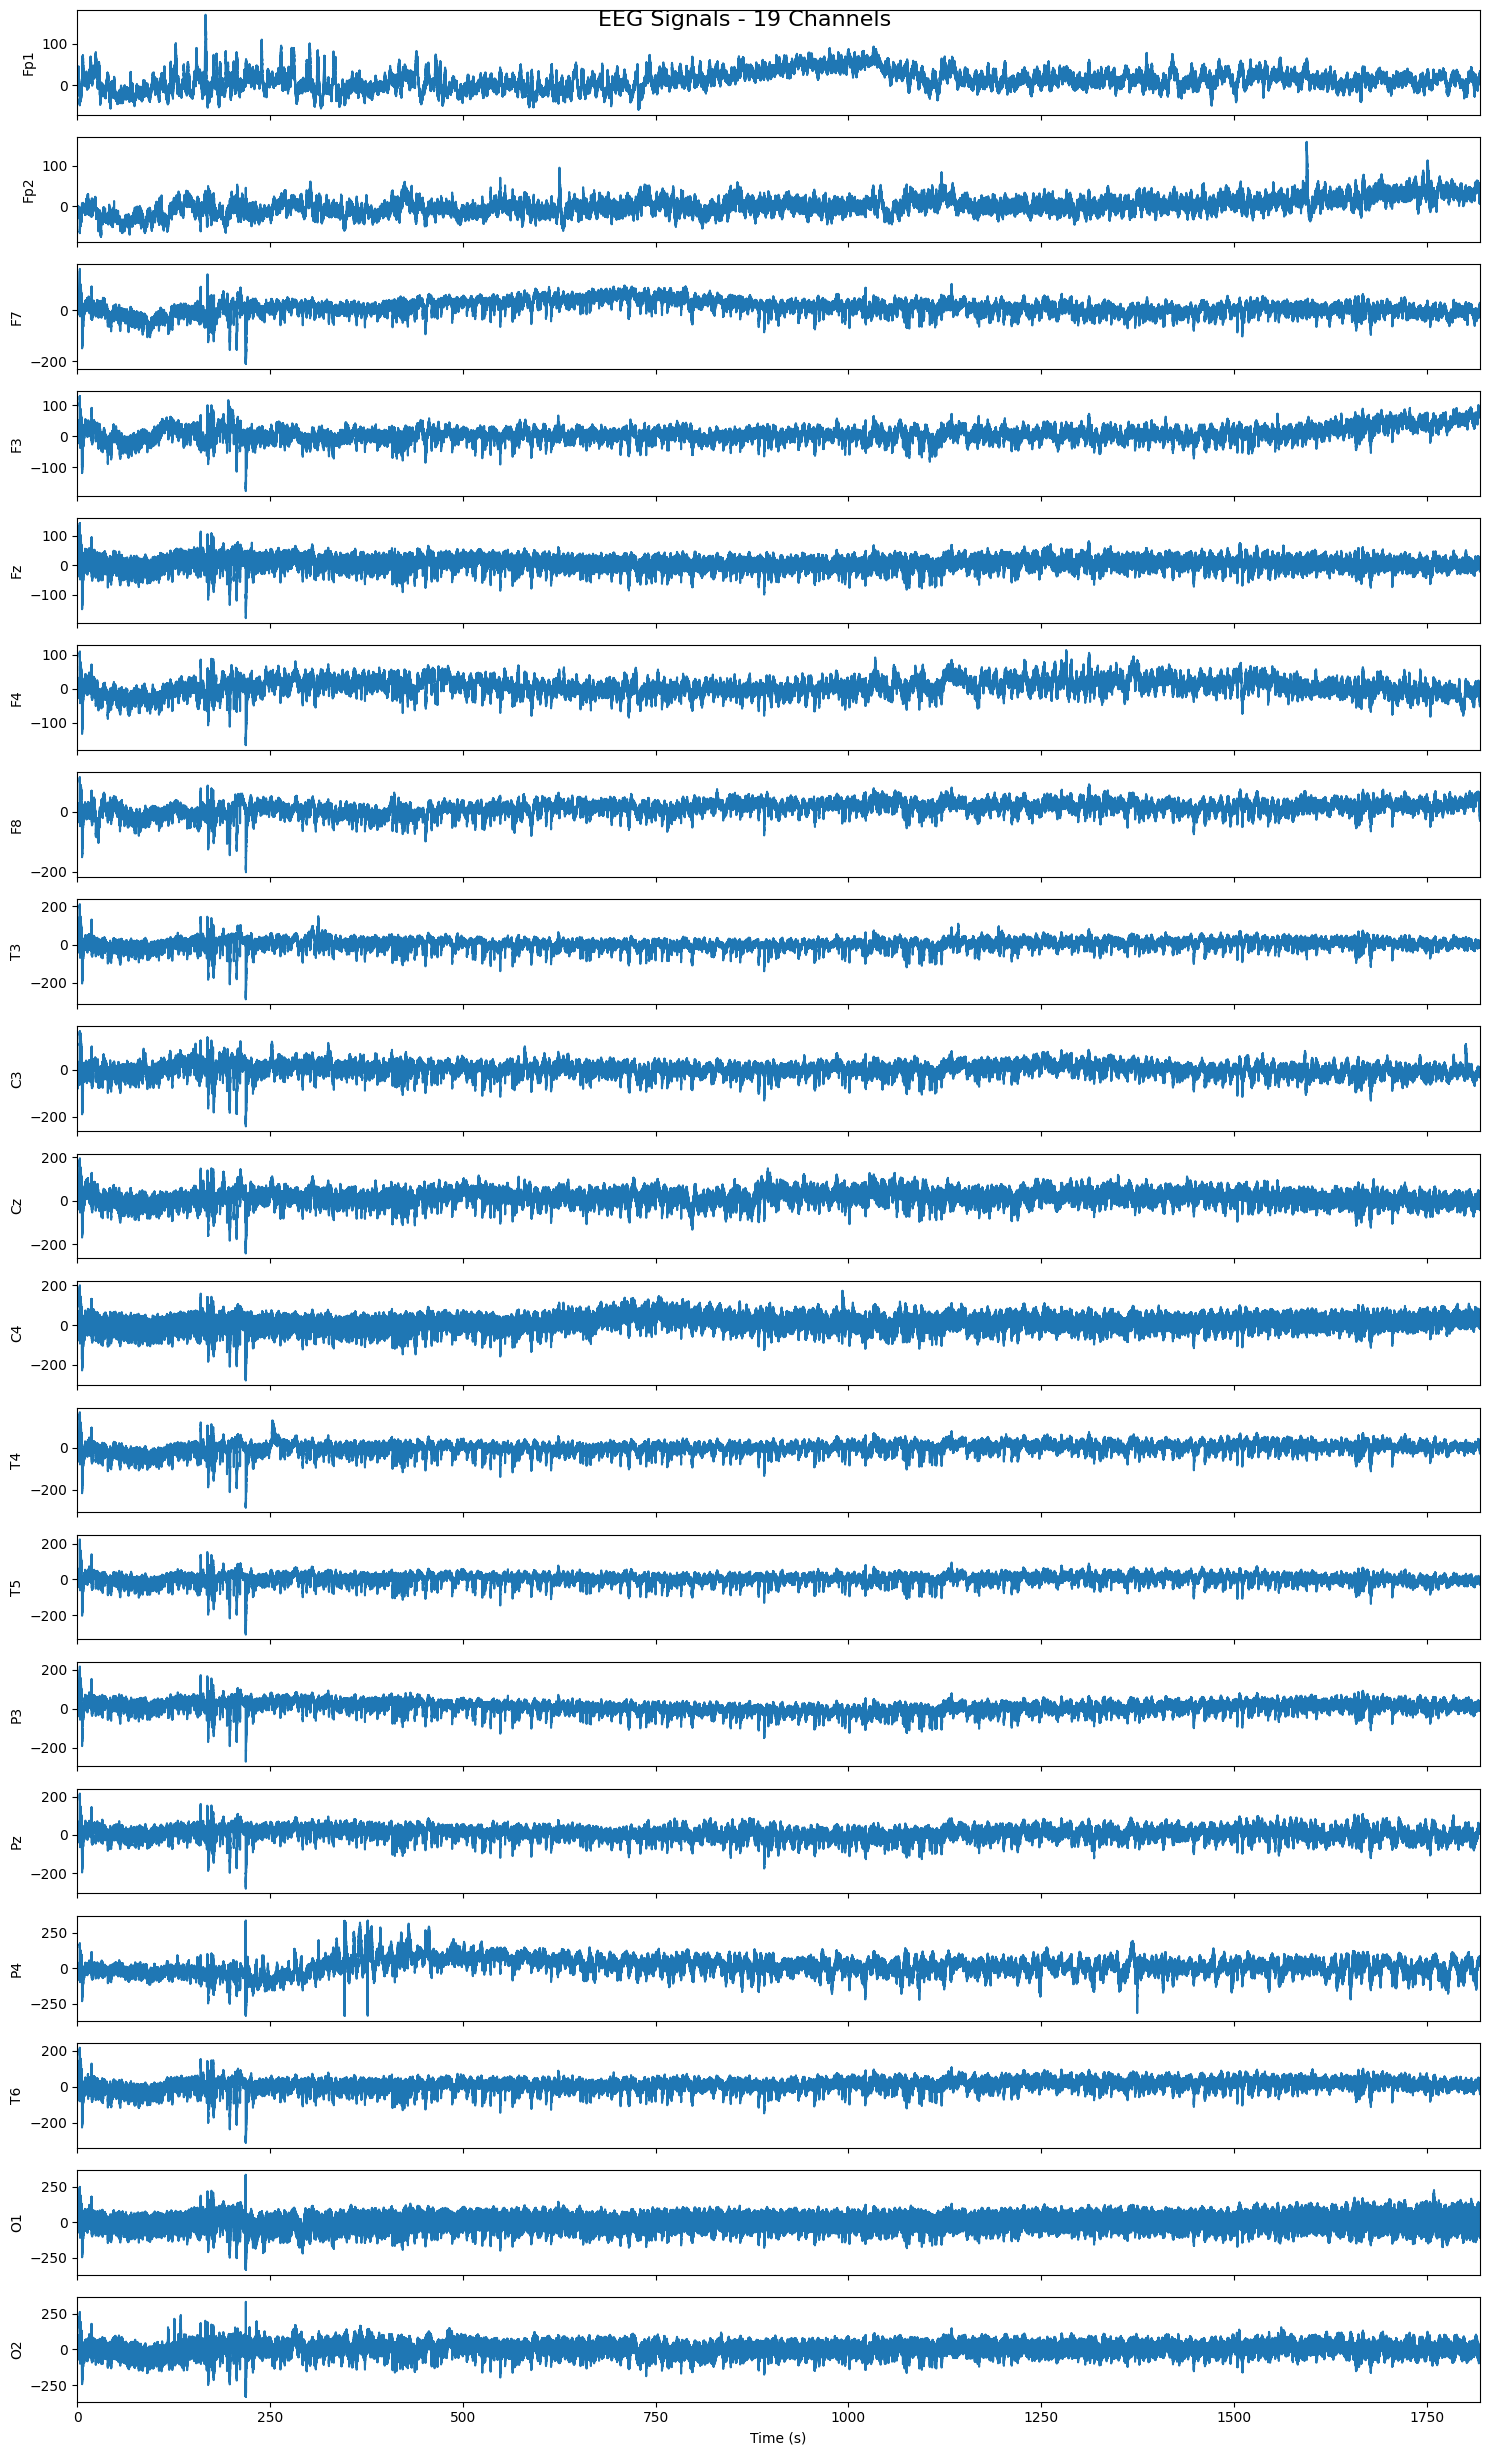

In [ ]:
import mne
import matplotlib.pyplot as plt

# Đường dẫn đến file .edf
edf_path = '/content/data1/1.edf'

# Đọc file .edf
raw = mne.io.read_raw_edf(edf_path, preload=True)

# Chọn 19 kênh đầu
raw.pick_types(eeg=True)
data, times = raw[:19, :]  # Lấy 19 kênh đầu

# Vẽ 19 tín hiệu trên cùng 1 hình (mỗi kênh 1 subplot)
fig, axs = plt.subplots(19, 1, figsize=(15, 25), sharex=True)
for i in range(19):
    axs[i].plot(times, data[i])
    axs[i].set_ylabel(raw.ch_names[i])
    axs[i].set_xlim(times[0], times[-1])

axs[-1].set_xlabel("Time (s)")
fig.suptitle("EEG Signals - 19 Channels", fontsize=16)
plt.tight_layout()
plt.show()


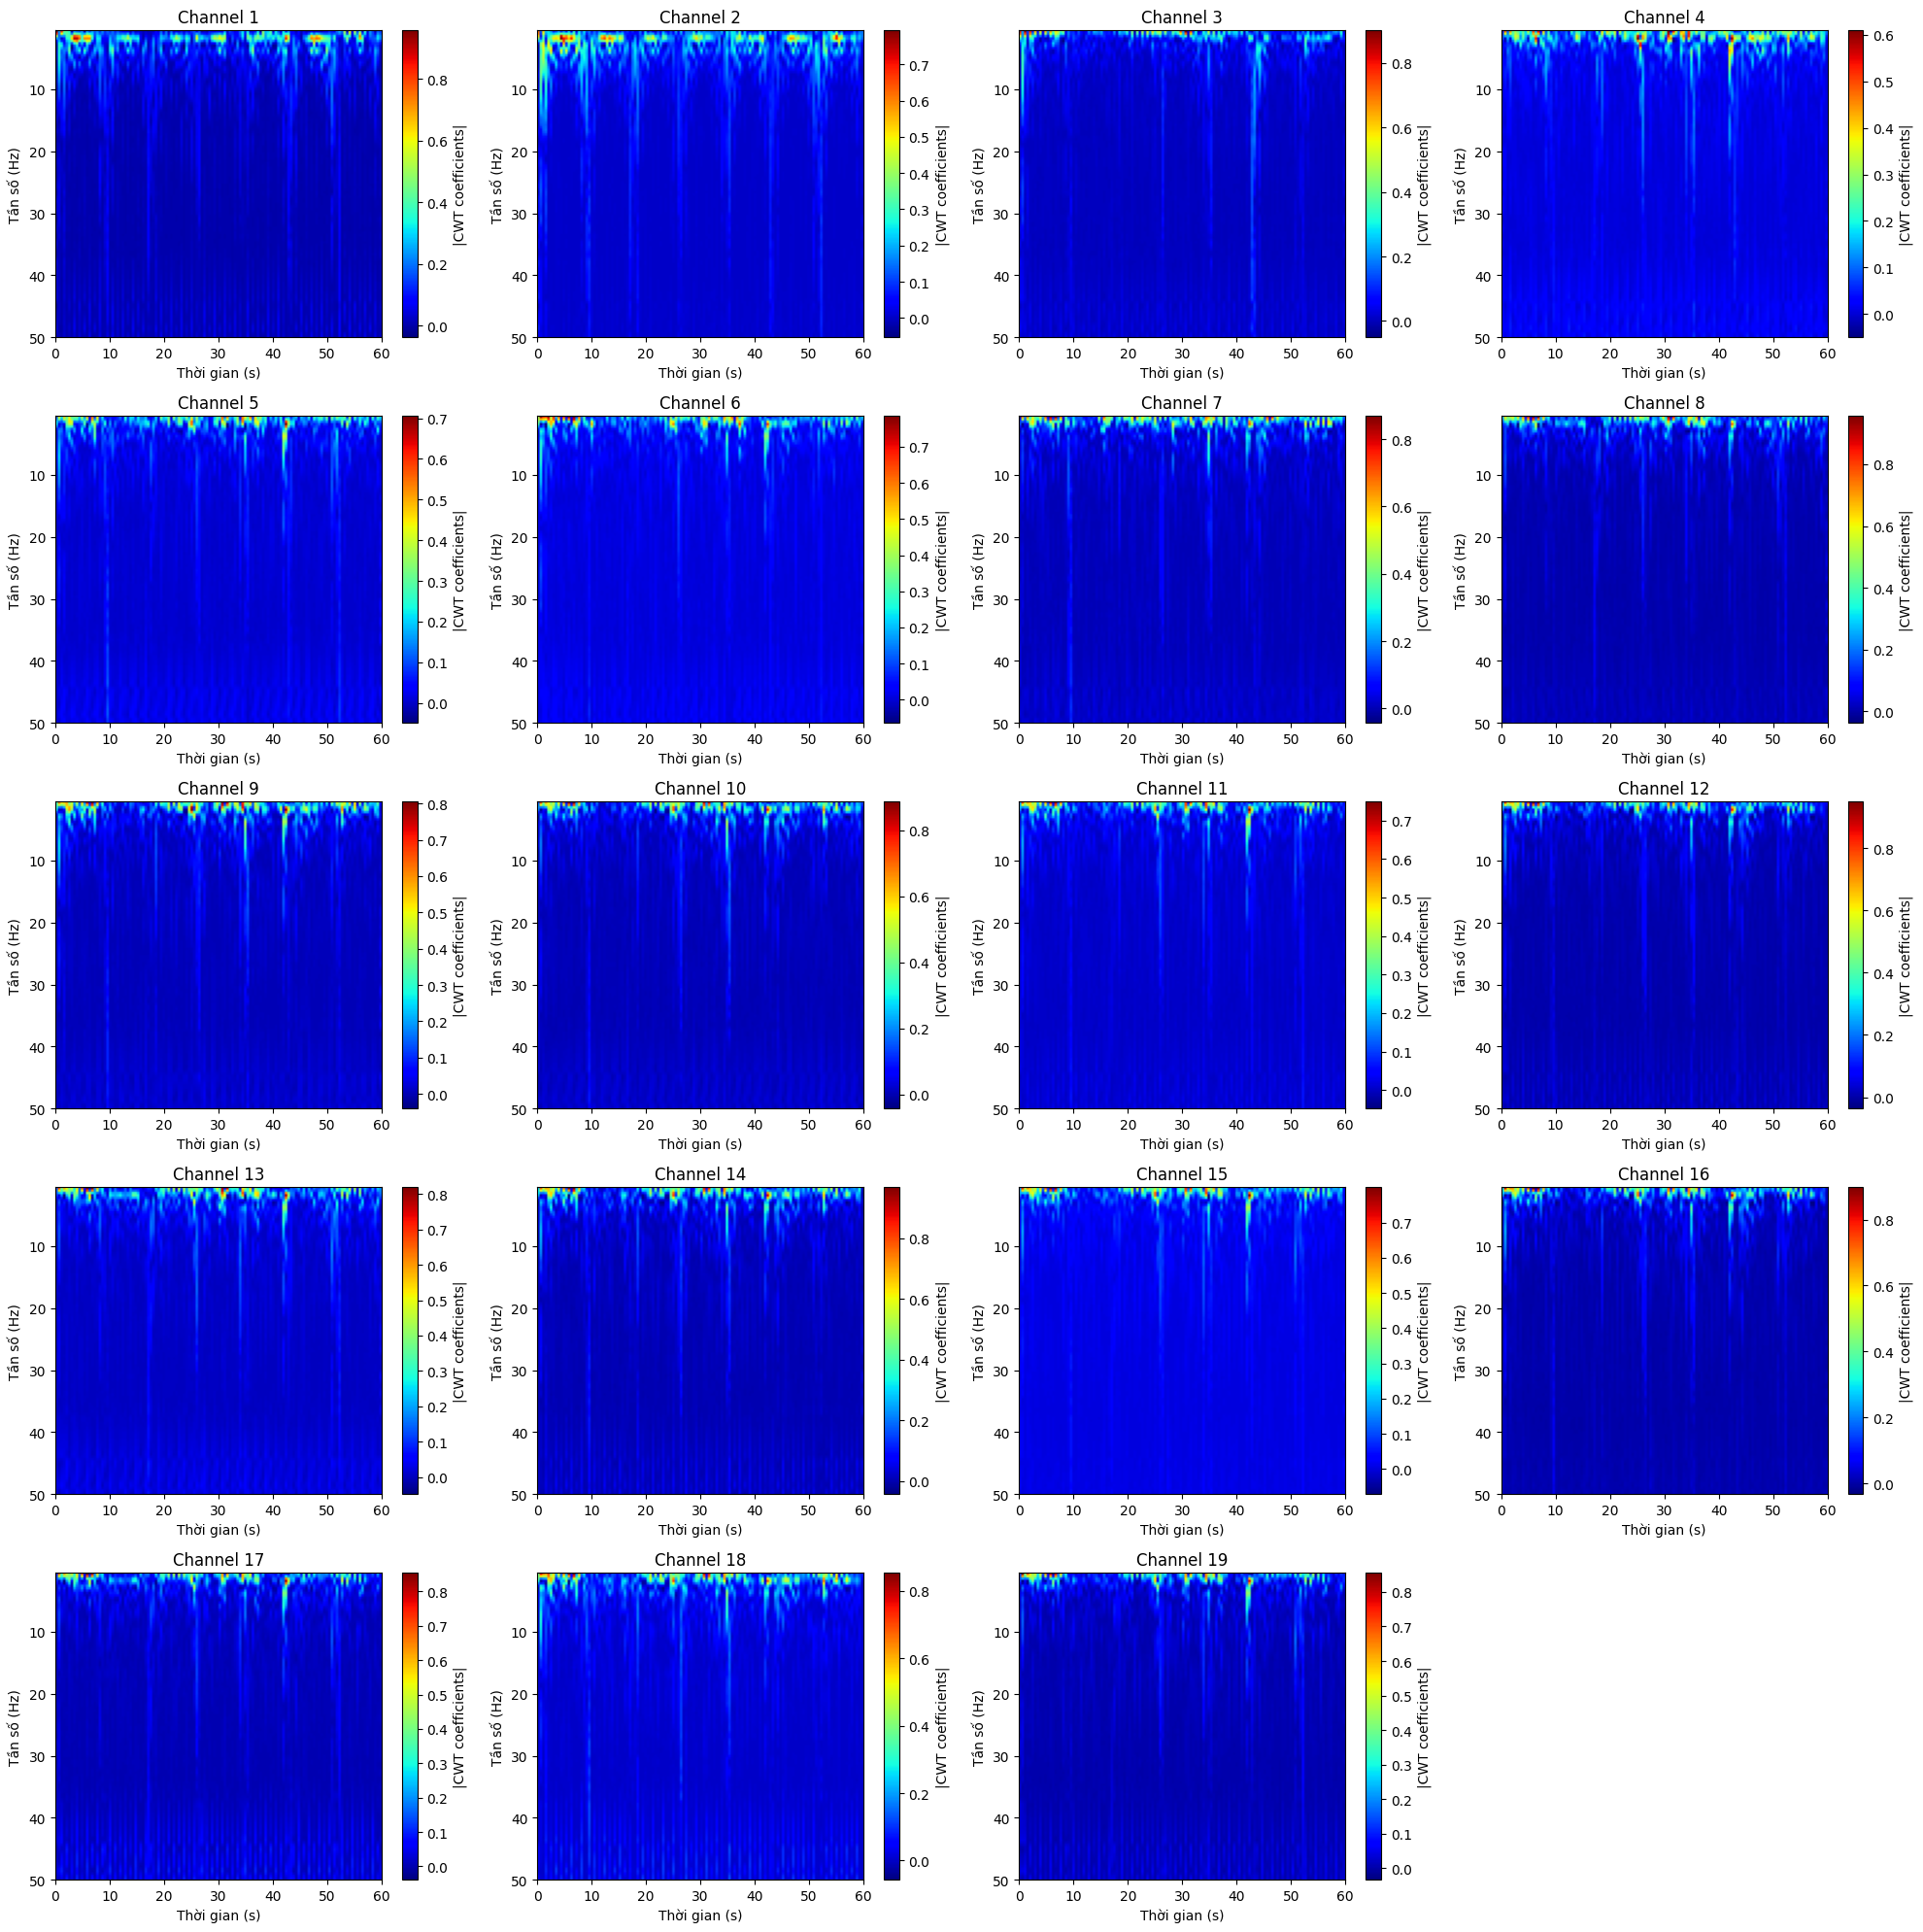

In [ ]:
import mne
import numpy as np
import matplotlib.pyplot as plt
import pywt
from scipy.ndimage import zoom
import gc  # Để giải phóng bộ nhớ

raw = mne.io.read_raw_edf("/content/data2/5.edf", preload=True, verbose=False)
signals, times = raw.get_data(return_times=True)  # Shape: (19, n_samples)

sfreq = raw.info['sfreq']  # Tần số lấy mẫu thực tế
duration_sec = 60
n_samples = int(sfreq * duration_sec)
segment = signals[:, 0:0 + n_samples]
wavelet = 'morl'  # Morlet wavelet
freqs_range = np.linspace(0.5, 50, 50)  # Tập trung vào 0.5–50 Hz
central_freq = pywt.central_frequency(wavelet)
scales = central_freq / (freqs_range * (1/sfreq))  # Tính scales dựa trên tần số

# Khởi tạo tensor 3D
tensor_3d = np.zeros((19, 128, 128))  # Shape: (19 channels, 128 freq, 128 time)

for ch in range(19):
    coefficients, freqs = pywt.cwt(segment[ch], scales, wavelet, sampling_period=1/sfreq)
    spectrogram = np.abs(coefficients)
    # Chuẩn hóa spectrogram về [0, 1]
    spectrogram = (spectrogram - spectrogram.min()) / (spectrogram.max() - spectrogram.min())
    # Resize spectrogram về 128x128
    spectrogram = zoom(spectrogram, (128/spectrogram.shape[0], 128/spectrogram.shape[1]))
    tensor_3d[ch, :, :] = spectrogram

# Bước 4: Trực quan hóa 19 ảnh spectrogram
plt.figure(figsize=(20, 20))
for ch in range(19):
    plt.subplot(5, 4, ch + 1)  # Sắp xếp thành lưới 5x4 (19 ảnh + 1 ô trống)
    plt.imshow(tensor_3d[ch], extent=[0, duration_sec, freqs[-1], freqs[0]],
               cmap='jet', aspect='auto')
    plt.title(f'Channel {ch + 1}')
    plt.xlabel("Thời gian (s)")
    plt.ylabel("Tần số (Hz)")
    plt.colorbar(label='|CWT coefficients|')
plt.tight_layout()
plt.show()

In [ ]:
raw_data[0].info

<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F7, F3, Fz, F4, F8, T3, C3, Cz, C4, T4, T5, P3, Pz, ...
 chs: 19 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 128.0 Hz
 meas_date: 2080-01-01 00:00:00 UTC
 nchan: 19
 projs: []
 sfreq: 256.0 Hz
 subject_info: <subject_info | his_id: >
>

Đã lưu xong patient 1 tại /content/drive/MyDrive/eeg/data_spectrogram/patient_1_30.npy
Đã lưu xong patient 2 tại /content/drive/MyDrive/eeg/data_spectrogram/patient_2_29.npy
Đã lưu xong patient 3 tại /content/drive/MyDrive/eeg/data_spectrogram/patient_3_30.npy
Đã lưu xong patient 4 tại /content/drive/MyDrive/eeg/data_spectrogram/patient_4_29.npy
Đã lưu xong patient 5 tại /content/drive/MyDrive/eeg/data_spectrogram/patient_5_32.npy
Đã lưu xong patient 6 tại /content/drive/MyDrive/eeg/data_spectrogram/patient_6_30.npy
Đã lưu xong patient 7 tại /content/drive/MyDrive/eeg/data_spectrogram/patient_7_30.npy
Đã lưu xong patient 8 tại /content/drive/MyDrive/eeg/data_spectrogram/patient_8_29.npy
Đã lưu xong patient 9 tại /content/drive/MyDrive/eeg/data_spectrogram/patient_9_34.npy
Đã lưu xong patient 10 tại /content/drive/MyDrive/eeg/data_spectrogram/patient_10_34.npy
Đã lưu xong patient 11 tại /content/drive/MyDrive/eeg/data_spectrogram/patient_11_30.npy
Đã lưu xong patient 12 tại /content/dri

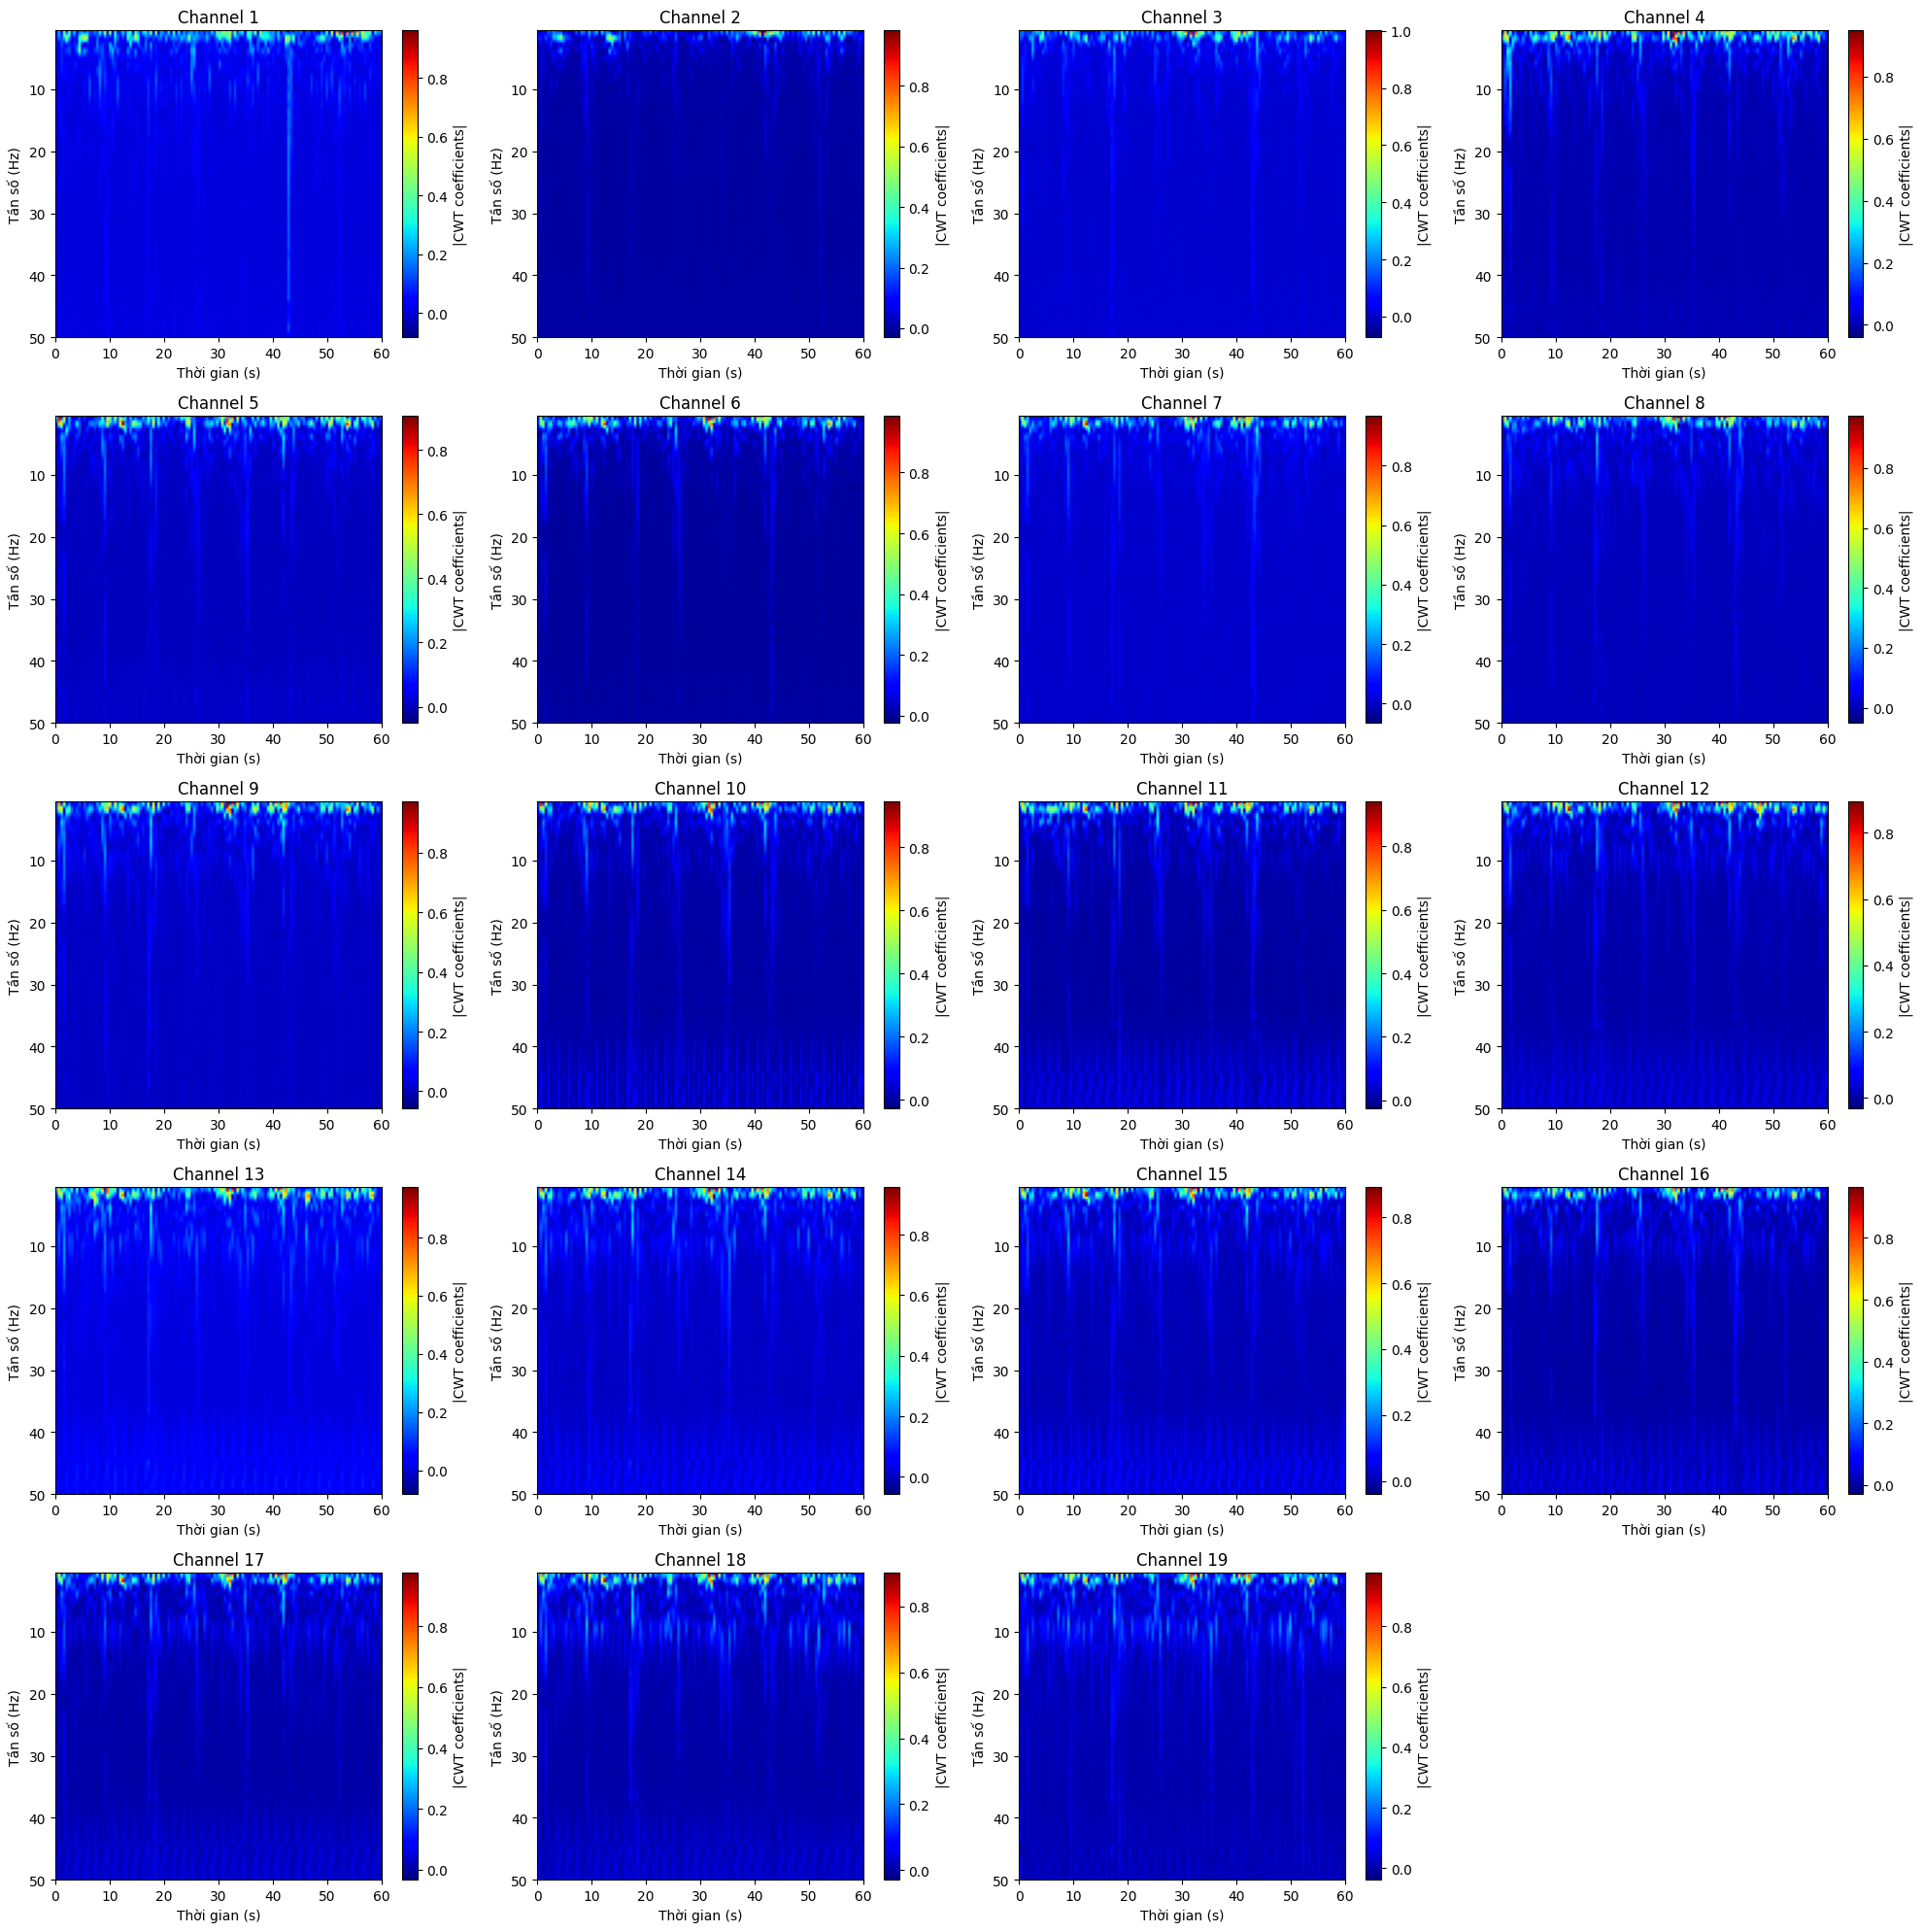

In [ ]:
import mne
import numpy as np
import matplotlib.pyplot as plt
import pywt
from scipy.ndimage import zoom
import os

for patient_id in range(61):
    raw = raw_data[patient_id]
    signals, times = raw.get_data(return_times=True)  # Shape: (19, n_samples)

    # Bước 2: Xác định tần số lấy mẫu và các tham số
    sfreq = raw.info['sfreq']  # Tần số lấy mẫu thực tế
    duration_sec = 60
    n_samples = int(sfreq * duration_sec)

    # Kiểm tra độ dài tín hiệu
    total_samples = signals.shape[1]
    if total_samples < n_samples:
        print(f"Warning: Signal length ({total_samples}) is shorter than requested epoch length ({n_samples}).")
        n_samples = total_samples

    # Tạo thư mục lưu trữ nếu chưa tồn tại
    output_dir = "/content/drive/MyDrive/eeg/data_spectrogram"
    os.makedirs(output_dir, exist_ok=True)

    # Bước 3: Áp dụng Continuous Wavelet Transform (CWT) và tạo tensor 3D cho từng epoch
    wavelet = 'morl'  # Morlet wavelet
    freqs_range = np.linspace(0.5, 50, 50)  # Tập trung vào 0.5–50 Hz
    central_freq = pywt.central_frequency(wavelet)
    scales = central_freq / (freqs_range * (1/sfreq))  # Tính scales dựa trên tần số

    # Lặp qua từng epoch
    for epoch_idx in range(0, total_samples, n_samples):
        segment = signals[:, epoch_idx:epoch_idx + n_samples]
        if segment.shape[1] < n_samples:  # Bỏ qua nếu đoạn cuối không đủ 10 giây
            continue

        # Tạo tensor 3D cho epoch hiện tại
        tensor_3d = np.zeros((19, 128, 128))  # Shape: (19 channels, 256 freq, 256 time)
        for ch in range(19):
            coefficients, freqs = pywt.cwt(segment[ch], scales, wavelet, sampling_period=1/sfreq)
            spectrogram = np.abs(coefficients)
            # Chuẩn hóa spectrogram về [0, 1]
            spectrogram = (spectrogram - spectrogram.min()) / (spectrogram.max() - spectrogram.min())
            # Resize spectrogram về 256x256
            spectrogram = zoom(spectrogram, (128/spectrogram.shape[0], 128/spectrogram.shape[1]))
            tensor_3d[ch, :, :] = spectrogram

        # Lưu tensor 3D vào file
        output_path = os.path.join(output_dir, f"patient_{patient_id+1}_{epoch_idx//n_samples}.npy")
        np.save(output_path, tensor_3d)
    print(f"Đã lưu xong patient {patient_id+1} tại {output_path}")

# Bước 4: (Tùy chọn) Trực quan hóa epoch đầu tiên để kiểm tra
plt.figure(figsize=(20, 20))
for ch in range(19):
    plt.subplot(5, 4, ch + 1)  # Sắp xếp thành lưới 5x4 (19 ảnh + 1 ô trống)
    plt.imshow(tensor_3d[ch], extent=[0, duration_sec, freqs[-1], freqs[0]],
               cmap='jet', aspect='auto')
    plt.title(f'Channel {ch + 1}')
    plt.xlabel("Thời gian (s)")
    plt.ylabel("Tần số (Hz)")
    plt.colorbar(label='|CWT coefficients|')
plt.tight_layout()
plt.show()

## 4. Load lại dữ liệu để đưa vào mô hình

In [ ]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch

# Giả định mảng labels (0: Normal, 1: MCI)

# 1. Đọc danh sách file mà không tải toàn bộ tensor vào RAM
data_dir = "/content/drive/MyDrive/eeg/data_spectrogram"
file_list = sorted(os.listdir(data_dir))  # Sắp xếp để đảm bảo thứ tự

# Lưu danh sách đường dẫn file và nhãn tương ứng
file_paths = []
file_labels = []
patient_to_files = {}  # Dictionary để lưu file theo patient_id

for file_name in file_list:
    if file_name.endswith(".npy"):
        patient_id = int(file_name.split("_")[1]) - 1  # Chuyển từ 1-based sang 0-based
        file_path = os.path.join(data_dir, file_name)
        file_paths.append(file_path)
        file_labels.append(labels[patient_id])

        if patient_id not in patient_to_files:
            patient_to_files[patient_id] = []
        patient_to_files[patient_id].append(file_path)

# 2. Chia tập train và test (stratified split theo patient_id)
patient_ids = np.arange(61)
train_ids, test_ids = train_test_split(patient_ids, test_size=0.2, stratify=labels, random_state=42)

# Tạo danh sách chỉ số cho tập train và test
train_indices = []
test_indices = []

for patient_id in train_ids:
    if patient_id in patient_to_files:
        # Tìm chỉ số của các file thuộc patient_id
        patient_files = patient_to_files[patient_id]
        indices = [file_paths.index(f) for f in patient_files]
        train_indices.extend(indices)

for patient_id in test_ids:
    if patient_id in patient_to_files:
        patient_files = patient_to_files[patient_id]
        indices = [file_paths.index(f) for f in patient_files]
        test_indices.extend(indices)

print(f"Số lượng tensor train: {len(train_indices)}")
print(f"Số lượng tensor test: {len(test_indices)}")
print(f"Tỷ lệ Normal/MCI trong train: {np.mean([file_labels[i] for i in train_indices]):.2f}")
print(f"Tỷ lệ Normal/MCI trong test: {np.mean([file_labels[i] for i in test_indices]):.2f}")

# 3. Tạo Dataset tùy chỉnh để tải tensor từ file khi cần
class EEGDataset(Dataset):
    def __init__(self, file_paths, labels, indices):
        self.file_paths = [file_paths[i] for i in indices]  # Chỉ lấy file thuộc tập train/test
        self.labels = [labels[i] for i in indices]

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        # Tải tensor từ file chỉ khi cần
        tensor = np.load(self.file_paths[idx]).astype(np.float32)
        label = self.labels[idx]
        return torch.FloatTensor(tensor), torch.FloatTensor([label])

# 4. Tạo DataLoader với batch size nhỏ để giảm tải RAM
batch_size = 16  # Giảm batch size để tránh tràn RAM
train_dataset = EEGDataset(file_paths, file_labels, train_indices)
test_dataset = EEGDataset(file_paths, file_labels, test_indices)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Kiểm tra số batch
print(f"Số batch trong train_loader: {len(train_loader)}")
print(f"Số batch trong test_loader: {len(test_loader)}")

# Ví dụ sử dụng DataLoader
for batch_tensors, batch_labels in train_loader:
    print(f"Kích thước batch tensor: {batch_tensors.shape}")  # [batch_size, 19, 128, 128]
    print(f"Kích thước batch label: {batch_labels.shape}")  # [batch_size, 1]
    break

Số lượng tensor train: 1472
Số lượng tensor test: 405
Tỷ lệ Normal/MCI trong train: 0.48
Tỷ lệ Normal/MCI trong test: 0.46
Số batch trong train_loader: 92
Số batch trong test_loader: 26
Kích thước batch tensor: torch.Size([16, 19, 128, 128])
Kích thước batch label: torch.Size([16, 1])


In [ ]:
!pip install captum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 50.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 112.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 106.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 97.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
!pip install sympy --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 44.9 MB/s eta 0:00:00
  Attempting uninstall: sympy
    Found existing installation: sympy 1.13.1
    Uninstalling sympy-1.13.1:
      Successfully uninstalled sympy-1.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires sympy==1.13.1; python_version >= "3.9", but you have sympy 1.14.0 which is incompatible.


## 5. Khởi tạo mô hình và huấn luyện

In [ ]:
import torch
import torch.nn as nn
import torchvision.models.video as models
from captum.attr import GuidedGradCam
import matplotlib.pyplot as plt

class EEG3DResNet(nn.Module):
    def __init__(self, weights="DEFAULT"):
        super(EEG3DResNet, self).__init__()

        self.model = models.r3d_18(weights=weights)
        self.model.stem[0] = nn.Conv3d(1, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)
        self.model.fc = nn.Sequential(
            nn.Linear(self.model.fc.in_features, 128),
            nn.ReLU(),
            nn.Dropout(0.7),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

ModuleNotFoundError: No module named 'captum'

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EEG3DResNet(weights="KINETICS400_V1").to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005, weight_decay=1e-4)

# 3. Huấn luyện mô hình và theo dõi loss, accuracy
num_epochs = 20
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

In [ ]:
from tqdm import tqdm
for epoch in range(num_epochs):
    # Huấn luyện
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    # Thêm progress bar cho tập train
    train_progress = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False)
    for batch_tensors, batch_labels in train_progress:
        batch_tensors, batch_labels = batch_tensors.to(device), batch_labels.to(device)

        # Thêm chiều kênh và resize tensor
        batch_tensors = batch_tensors.unsqueeze(1)
        batch_tensors = torch.nn.functional.interpolate(batch_tensors, size=(19, 112, 112), mode='trilinear', align_corners=False)

        optimizer.zero_grad()
        outputs = model(batch_tensors)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        predicted = (outputs >= 0.5).float()
        train_total += batch_labels.size(0)
        train_correct += (predicted == batch_labels).sum().item()

        # Cập nhật thông tin trên progress bar
        train_progress.set_postfix({"loss": train_loss / (train_progress.n + 1)})

    # Tính trung bình loss và accuracy trên tập train
    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = train_correct / train_total
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # Đánh giá trên tập test
    model.eval()
    test_loss = 0.0
    test_correct = 0
    test_total = 0

    # Thêm progress bar cho tập test
    test_progress = tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Test]", leave=False)
    with torch.no_grad():
        for batch_tensors, batch_labels in test_progress:
            batch_tensors, batch_labels = batch_tensors.to(device), batch_labels.to(device)
            batch_tensors = batch_tensors.unsqueeze(1)
            batch_tensors = torch.nn.functional.interpolate(batch_tensors, size=(19, 112, 112), mode='trilinear', align_corners=False)
            outputs = model(batch_tensors)
            loss = criterion(outputs, batch_labels)

            test_loss += loss.item()
            predicted = (outputs >= 0.5).float()
            test_total += batch_labels.size(0)
            test_correct += (predicted == batch_labels).sum().item()

            # Cập nhật thông tin trên progress bar
            test_progress.set_postfix({"loss": test_loss / (test_progress.n + 1)})

    # Tính trung bình loss và accuracy trên tập test
    avg_test_loss = test_loss / len(test_loader)
    test_accuracy = test_correct / test_total
    test_losses.append(avg_test_loss)
    test_accuracies.append(test_accuracy)

    # Hiển thị kết quả sau mỗi epoch
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
    print("-" * 50)

Epoch [1/20]
Train Loss: 0.5994, Train Accuracy: 0.6834
Test Loss: 0.6860, Test Accuracy: 0.6173
--------------------------------------------------


Epoch [2/20]
Train Loss: 0.2869, Train Accuracy: 0.9008
Test Loss: 0.9626, Test Accuracy: 0.5012
--------------------------------------------------


Epoch [3/20]
Train Loss: 0.1412, Train Accuracy: 0.9640
Test Loss: 1.4665, Test Accuracy: 0.4617
--------------------------------------------------


Epoch [4/20]
Train Loss: 0.0767, Train Accuracy: 0.9830
Test Loss: 1.3171, Test Accuracy: 0.5185
--------------------------------------------------


Epoch [5/20]
Train Loss: 0.0756, Train Accuracy: 0.9749
Test Loss: 1.6105, Test Accuracy: 0.5086
--------------------------------------------------


Epoch [6/20]
Train Loss: 0.0508, Train Accuracy: 0.9851
Test Loss: 1.9203, Test Accuracy: 0.4469
--------------------------------------------------


Epoch [7/20]
Train Loss: 0.0225, Train Accuracy: 0.9973
Test Loss: 1.8127, Test Accuracy: 0.4716
--------------------------------------------------


Epoch [8/20]
Train Loss: 0.0203, Train Accuracy: 0.9946
Test Loss: 1.9021, Test Accuracy: 0.5383
--------------------------------------------------


Epoch [9/20]
Train Loss: 0.0520, Train Accuracy: 0.9844
Test Loss: 2.0130, Test Accuracy: 0.4914
--------------------------------------------------


Epoch [10/20]
Train Loss: 0.0183, Train Accuracy: 0.9966
Test Loss: 1.9316, Test Accuracy: 0.5407
--------------------------------------------------


Epoch [11/20]
Train Loss: 0.0264, Train Accuracy: 0.9925
Test Loss: 2.1798, Test Accuracy: 0.5506
--------------------------------------------------


Epoch [12/20]
Train Loss: 0.0089, Train Accuracy: 0.9993
Test Loss: 1.8925, Test Accuracy: 0.5531
--------------------------------------------------


Epoch [13/20]
Train Loss: 0.0036, Train Accuracy: 1.0000
Test Loss: 2.1889, Test Accuracy: 0.5679
--------------------------------------------------


Epoch [14/20]
Train Loss: 0.0032, Train Accuracy: 1.0000
Test Loss: 2.1963, Test Accuracy: 0.5901
--------------------------------------------------


Epoch [15/20]
Train Loss: 0.0330, Train Accuracy: 0.9891
Test Loss: 1.6042, Test Accuracy: 0.6123
--------------------------------------------------


Epoch [16/20]
Train Loss: 0.0205, Train Accuracy: 0.9946
Test Loss: 2.2549, Test Accuracy: 0.4963
--------------------------------------------------


Epoch [17/20]
Train Loss: 0.0246, Train Accuracy: 0.9918
Test Loss: 2.0538, Test Accuracy: 0.6272
--------------------------------------------------


Epoch [18/20]
Train Loss: 0.0108, Train Accuracy: 0.9966
Test Loss: 2.1033, Test Accuracy: 0.6074
--------------------------------------------------


Epoch [19/20]
Train Loss: 0.0025, Train Accuracy: 1.0000
Test Loss: 2.1772, Test Accuracy: 0.5827
--------------------------------------------------


Epoch [20/20]
Train Loss: 0.0026, Train Accuracy: 1.0000
Test Loss: 2.2235, Test Accuracy: 0.5654
--------------------------------------------------


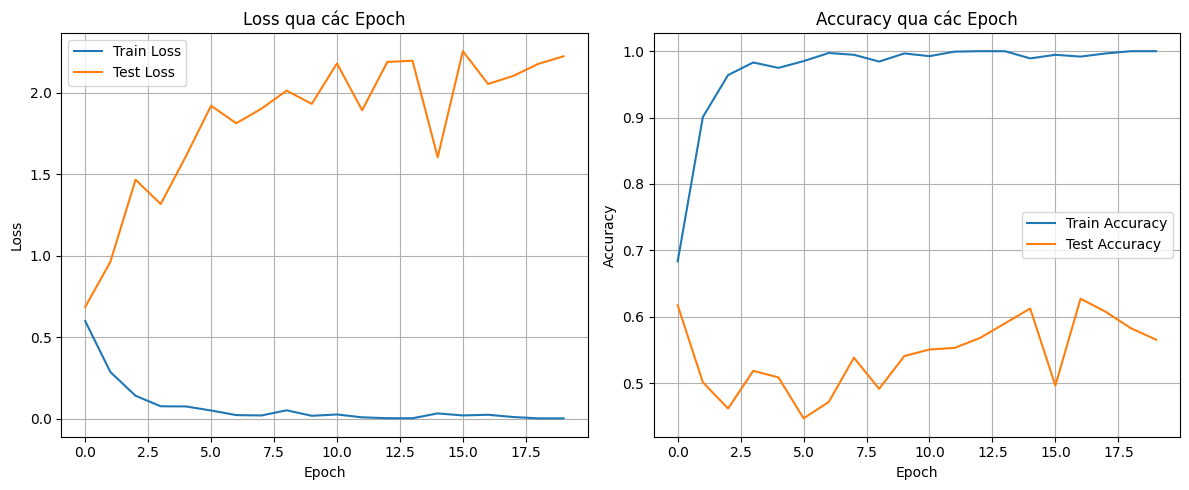

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss qua các Epoch')
plt.legend()
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy qua các Epoch')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Shape of attributions: torch.Size([1, 1, 19, 112, 112])


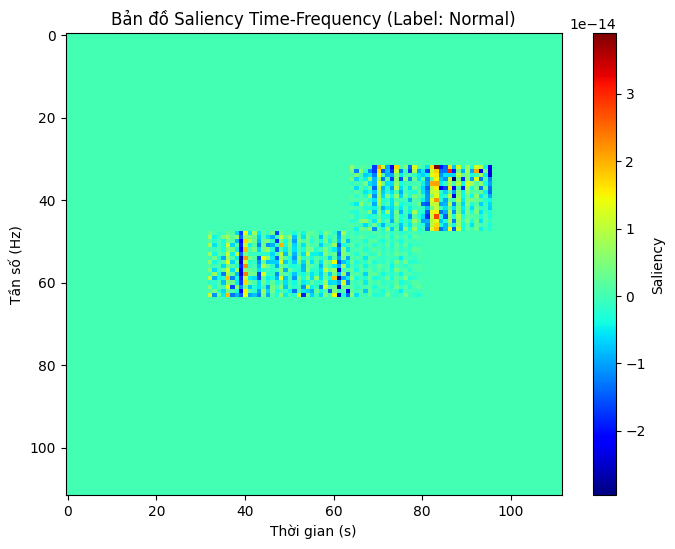

Shape of channel_saliency: (19,)


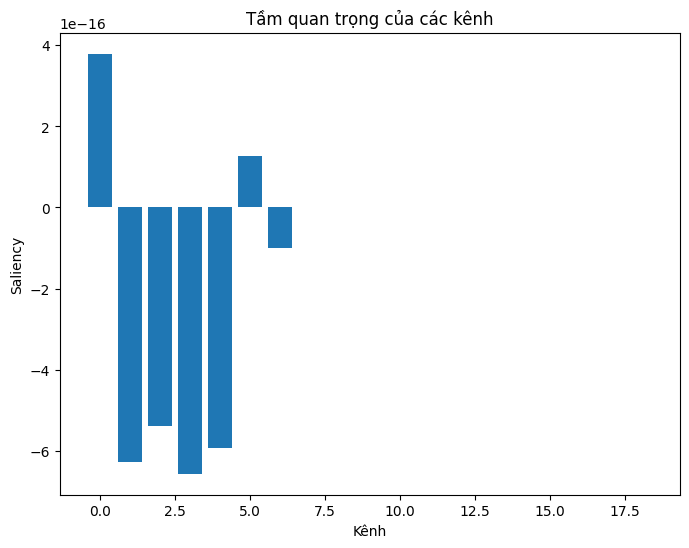

In [ ]:
# 5. Tích hợp 3D Grad-CAM để giải thích
sample_tensor, sample_label = next(iter(test_loader))
sample_tensor, sample_label = sample_tensor[0:1].to(device), sample_label[0:1].to(device)
sample_tensor = sample_tensor.unsqueeze(1)
sample_tensor = torch.nn.functional.interpolate(sample_tensor, size=(19, 112, 112), mode='trilinear', align_corners=False)

target_layer = model.model.layer4[-1]
ggc = GuidedGradCam(model, target_layer)
attributions = ggc.attribute(sample_tensor, target=int(sample_label.item()))

print("Shape of attributions:", attributions.shape)

# 6. Trực quan hóa bản đồ saliency
avg_saliency = attributions.mean(dim=1).squeeze().cpu().detach().numpy()
if avg_saliency.ndim != 2:
    avg_saliency = avg_saliency.mean(axis=0)
plt.figure(figsize=(8, 6))
plt.imshow(avg_saliency, cmap='jet', aspect='auto')
plt.colorbar(label='Saliency')
plt.xlabel("Thời gian (s)")
plt.ylabel("Tần số (Hz)")
plt.title(f"Bản đồ Saliency Time-Frequency (Label: {'MCI' if sample_label.item() == 1 else 'Normal'})")
plt.show()

# Trung bình theo thời gian và tần số để lấy tầm quan trọng của kênh
channel_saliency = attributions.squeeze(0).mean(dim=(2, 3)).cpu().detach().numpy()  # Giảm từ [1, 19, 112, 112] thành [1, 19]
channel_saliency = channel_saliency.squeeze()  # Đảm bảo shape là (19,)
print("Shape of channel_saliency:", channel_saliency.shape)
plt.figure(figsize=(8, 6))
plt.bar(range(19), channel_saliency)
plt.xlabel("Kênh")
plt.ylabel("Saliency")
plt.title("Tầm quan trọng của các kênh")
plt.show()

In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/eeg/model_r3d_spec.pth")

## 6. Trích xuất spectrogram 2D

Extracting EDF parameters from /content/data1/1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 465663  =      0.000 ...  1818.996 secs...
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 6.7s.
Không tìm thấy kênh EOG, dùng Fp1 và Fp2 làm kênh EOG thay thế...
Using EOG channels: Fp1, Fp2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 sam

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Thành phần nháy mắt: [np.int64(2)]
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 19 PCA components


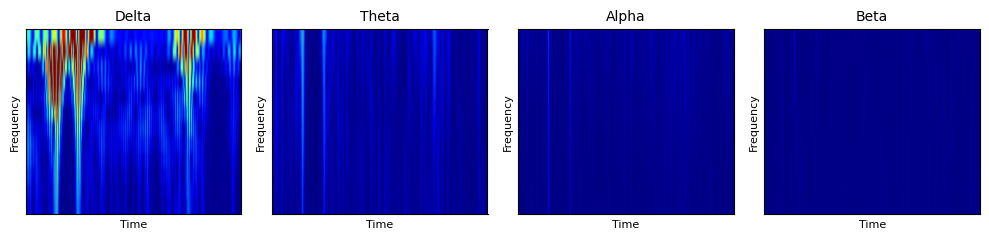

In [ ]:
import mne
import numpy as np
import matplotlib.pyplot as plt
import pywt
import os

# Đọc dữ liệu EEG từ tệp .edf
raw = mne.io.read_raw_edf('/content/data1/1.edf',preload=True)
raw.filter(l_freq=0.5, h_freq=40, fir_design='firwin', verbose=False)
    # Chuẩn hóa dữ liệu
data = raw.get_data()
data = (data - data.mean(axis=1, keepdims=True)) / data.std(axis=1, keepdims=True)
raw._data = data

# Fit ICA
ica = ICA(n_components=15, random_state=42, max_iter=800)
ica.fit(raw)

# Kiểm tra và đặt kênh EOG
eog_channels = [ch for ch in raw.ch_names if 'EOG' in ch.upper()]
if not eog_channels:
    print("Không tìm thấy kênh EOG, dùng Fp1 và Fp2 làm kênh EOG thay thế...")
    raw.set_channel_types({'Fp1': 'eog', 'Fp2': 'eog'})
    eog_indices, eog_scores = ica.find_bads_eog(raw, ch_name=['Fp1', 'Fp2'])
    raw.set_channel_types({'Fp1': 'eeg', 'Fp2': 'eeg'})  # Đặt lại
else:
    eog_indices, eog_scores = ica.find_bads_eog(raw)

# Gán thành phần nhiễu
ica.exclude = eog_indices
print(f'Thành phần nháy mắt: {eog_indices}')

# Áp dụng ICA
raw_clean = ica.apply(raw.copy())
raw._data = raw_clean.get_data()

signals, times = raw.get_data(return_times=True)  # Shape: (19, n_samples)
sfreq = raw.info['sfreq']  # Tần số lấy mẫu thực tế
# Tham số
duration_sec = 25 # Epoch 4s cho 500 Hz, 3s cho 256 Hz
n_samples = int(sfreq * duration_sec)
if n_samples > signals.shape[1]:
    n_samples = signals.shape[1]
segment = signals[:,0* n_samples: 0*n_samples + n_samples ]

# Sử dụng wavelet Morlet
wavelet = 'morl'
freqs_range = np.linspace(0.5, 32, 100)
central_freq = pywt.central_frequency(wavelet)
scales = central_freq / (freqs_range * (1/sfreq))

# Tính CWT và xếp chồng
spectrograms = np.zeros((19, len(scales), n_samples))
for ch in range(19):
    coefficients, freqs = pywt.cwt(segment[ch], scales, wavelet, sampling_period=1/sfreq)
    spectrograms[ch] = np.abs(coefficients)

# Trung bình hóa trên 19 kênh
spectrogram_combined = np.mean(spectrograms, axis=0)
spectrogram_combined = (spectrogram_combined - spectrogram_combined.min()) / (spectrogram_combined.max() - spectrogram_combined.min())

# Trích xuất 4 dải tần số
freq_bands = {
    'Delta': (0.5, 4),
    'Theta': (4, 8),
    'Alpha': (8, 13),
    'Beta': (13, 25)
}

band_spectrograms = {}
for band, (fmin, fmax) in freq_bands.items():
    freq_idx = np.where((freqs >= fmin) & (freqs <= fmax))[0]
    band_spectrograms[band] = spectrogram_combined[freq_idx, :]

# Tạo thư mục lưu trữ hình ảnh PNG
output_dir = "/content/data2/spectrograms"
os.makedirs(output_dir, exist_ok=True)

# Trực quan hóa và lưu từng spectrogram tổng hợp dưới dạng PNG
plt.figure(figsize=(10, 2.5))
for idx, band in enumerate(['Delta', 'Theta', 'Alpha', 'Beta']):
    plt.subplot(1, 4, idx + 1)
    plt.imshow(band_spectrograms[band], cmap='jet', aspect='auto', extent=[0, duration_sec, fmax, fmin], vmin=0, vmax=0.5)
    plt.title(f'{band}', fontsize=10)
    plt.xlabel('Time', fontsize=8)
    plt.ylabel('Frequency', fontsize=8)
    plt.xticks([])
    plt.yticks([])

    # Lưu từng spectrogram tổng hợp dưới dạng PNG
    plt.figure(figsize=(3, 3))
    plt.imshow(band_spectrograms[band], cmap='jet', aspect='auto', extent=[0, duration_sec, fmax, fmin], vmin=0, vmax=0.5)
    plt.title(f'{band}', fontsize=10)
    plt.xlabel('Time', fontsize=8)
    plt.ylabel('Frequency', fontsize=8)
    plt.xticks([])
    plt.yticks([])
    plt.savefig(os.path.join(output_dir, f"spectrogram_{band}.png"), bbox_inches='tight')
    plt.close()

plt.tight_layout()
plt.show()

In [ ]:
def create_spectrograms(segment, sfreq, output_dir, patient_id, label, epoch_idx):
    wavelet = 'morl'
    freqs_range = np.linspace(0.5, 32, 100)
    central_freq = pywt.central_frequency(wavelet)
    scales = central_freq / (freqs_range * (1/sfreq))

    # Tính CWT và xếp chồng
    spectrograms = np.zeros((19, len(scales), n_samples))
    for ch in range(19):
        coefficients, freqs = pywt.cwt(segment[ch], scales, wavelet, sampling_period=1/sfreq)
        spectrograms[ch] = np.abs(coefficients)

    # Trung bình hóa trên 19 kênh
    spectrogram_combined = np.mean(spectrograms, axis=0)
    spectrogram_combined = (spectrogram_combined - spectrogram_combined.min()) / (spectrogram_combined.max() - spectrogram_combined.min())

    # Trích xuất 4 dải tần số
    freq_bands = {
        'Delta': (0.5, 4),
        'Theta': (4, 8),
        'Alpha': (8, 13),
        'Beta': (13, 25)
    }

    band_spectrograms = {}
    for band, (fmin, fmax) in freq_bands.items():
        freq_idx = np.where((freqs >= fmin) & (freqs <= fmax))[0]
        band_spectrograms[band] = spectrogram_combined[freq_idx, :]

    # Lưu từng spectrogram dưới dạng PNG
    os.makedirs(output_dir, exist_ok=True)
    for band, spectrogram in band_spectrograms.items():
        plt.figure(figsize=(3, 3))
        plt.imshow(spectrogram, cmap='jet', aspect='auto', extent=[0, duration_sec, fmax, fmin], vmin=0, vmax=0.5)
        plt.xticks([])
        plt.yticks([])
        plt.savefig(os.path.join(output_dir, f"patient_{patient_id}_epoch_{epoch_idx}_{band}.png"), bbox_inches='tight', dpi=100)
        plt.close()
        plt.clf()    # Xóa bộ nhớ đệm của matplotlib

    # Giải phóng bộ nhớ
    del spectrograms, spectrogram_combined, band_spectrograms
    gc.collect()

In [ ]:
import random
import gc  # Để giải phóng bộ nhớ
max_epochs_per_patient = 600  # Giới hạn kỹ thuật
max_epochs_per_patient_target = 30 # Giới hạn mục tiêu mỗi bệnh nhân
target_total_epochs = 2562  # Mục tiêu tổng cộng 2,562 epoch
output_dir_mci = os.path.join( "/content/drive/MyDrive/eeg/MCI_new/")
output_dir_nc = os.path.join( "/content/drive/MyDrive/eeg/NC_new/")
for patient_id in range(1, 62):
      # Đọc dữ liệu
      raw = raw_data[patient_id-1]
      signals, times = raw.get_data(return_times=True)
      sfreq = raw.info['sfreq']
      # Gán nhãn
      if labels[patient_id-1] == 0:
         label = "NC"
      else:
         label = "MCI"

      # Tính số epoch tối đa có thể trích xuất
      duration_sec = 4
      n_samples = int(sfreq * duration_sec)
      total_samples = signals.shape[1]
      num_epochs = min(max_epochs_per_patient, total_samples // n_samples)

      # Trích xuất từng epoch
      patient_epochs = []
      for epoch_idx in range(num_epochs):
          start_idx = epoch_idx * n_samples
          end_idx = start_idx + n_samples
          if end_idx > total_samples:
              break
          segment = signals[:, start_idx:end_idx]
          patient_epochs.append((patient_id, label, epoch_idx, segment))

      selected_patient_epochs = random.sample(patient_epochs, max_epochs_per_patient_target)
      for patient_id, label, epoch_idx, segment in selected_patient_epochs:
            output_dir = output_dir_mci if label == "MCI" else output_dir_nc
            create_spectrograms(segment, sfreq, output_dir, patient_id, label, epoch_idx)
      # all_epochs.extend(selected_patient_epochs)

      print(f"Đã thêm {len(selected_patient_epochs)} epoch cho bệnh nhân {patient_id} ({label})")
      del signals, patient_epochs, selected_patient_epochs
      gc.collect()


Đã thêm 30 epoch cho bệnh nhân 1 (NC)
Đã thêm 30 epoch cho bệnh nhân 2 (MCI)
Đã thêm 30 epoch cho bệnh nhân 3 (MCI)
Đã thêm 30 epoch cho bệnh nhân 4 (NC)
Đã thêm 30 epoch cho bệnh nhân 5 (NC)
Đã thêm 30 epoch cho bệnh nhân 6 (MCI)
Đã thêm 30 epoch cho bệnh nhân 7 (MCI)
Đã thêm 30 epoch cho bệnh nhân 8 (NC)
Đã thêm 30 epoch cho bệnh nhân 9 (MCI)
Đã thêm 30 epoch cho bệnh nhân 10 (NC)
Đã thêm 30 epoch cho bệnh nhân 11 (MCI)
Đã thêm 30 epoch cho bệnh nhân 12 (NC)
Đã thêm 30 epoch cho bệnh nhân 13 (NC)
Đã thêm 30 epoch cho bệnh nhân 14 (MCI)
Đã thêm 30 epoch cho bệnh nhân 15 (MCI)
Đã thêm 30 epoch cho bệnh nhân 16 (NC)
Đã thêm 30 epoch cho bệnh nhân 17 (NC)
Đã thêm 30 epoch cho bệnh nhân 18 (NC)
Đã thêm 30 epoch cho bệnh nhân 19 (NC)
Đã thêm 30 epoch cho bệnh nhân 20 (MCI)
Đã thêm 30 epoch cho bệnh nhân 21 (NC)
Đã thêm 30 epoch cho bệnh nhân 22 (NC)
Đã thêm 30 epoch cho bệnh nhân 23 (MCI)
Đã thêm 30 epoch cho bệnh nhân 24 (NC)
Đã thêm 30 epoch cho bệnh nhân 25 (MCI)
Đã thêm 30 epoch cho bệ

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
